In [1]:
import os
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import numpy as np
from skimage import exposure
from skimage import data, img_as_float
from skimage.io import imsave, imread
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd
import geopandas as gpd
from shapely.geometry import box
from fiona.crs import from_epsg

# VARIABLES AND FOLDERS

In [2]:
sat_img_folders = "landsat_8_2022" # "landsat_7_1999" # 

project_path = "./"
list_main_folders = os.listdir(project_path)

polygon_aoi = "./aoi/"+"poly_ciudad_32621.geojson"
polygons_sample = "./muestras/shp/muestras_"+sat_img_folders+".geojson"
crs_epsg = 32621

In [3]:
""" 
Project Structure

    main folder
    |- aoi              # area of interes plygons and images
        |- *img_sat*
    |- img_sat          # satellite images
        |- *img_sat*
    |- indices          # norm indexes bands
        |- *img_sat*
    |- convoluciones    # convolution bands
        |- *img_sat*
    |- muestras
        |- shp          # polygons to clip images
        |- *img_sat*    # image clips
"""


if "img_sat" not in list_main_folders:
    os.mkdir(project_path+"img_sat")
if sat_img_folders not in os.listdir(project_path+"img_sat"):
    os.mkdir(project_path+"img_sat/"+sat_img_folders)

if "indices" not in list_main_folders:
    os.mkdir(project_path+"indices")
if sat_img_folders not in os.listdir(project_path+"indices"):
    os.mkdir(project_path+"indices/"+sat_img_folders)

if "convoluciones" not in list_main_folders:
    os.mkdir(project_path+"convoluciones")
if sat_img_folders not in os.listdir(project_path+"convoluciones"):
    os.mkdir(project_path+"convoluciones/"+sat_img_folders)

if "muestras" not in list_main_folders:
    os.mkdir(project_path+"muestras")
if sat_img_folders not in os.listdir(project_path+"muestras"):
    os.mkdir(project_path+"muestras/"+sat_img_folders)
if "shp" not in os.listdir(project_path+"muestras"):
    os.mkdir(project_path+"muestras/shp")

if "aoi" not in list_main_folders:
    os.mkdir(project_path+"aoi")
if sat_img_folders not in os.listdir(project_path+"aoi"):
    os.mkdir(project_path+"aoi/"+sat_img_folders)

if "shp" not in list_main_folders:
    os.mkdir(project_path+"shp")

In [4]:
# path to folder
path_dir = "./img_sat/"+sat_img_folders+"/"

# bands images names
file_list = []
for img in os.listdir(path_dir):
    file_list.append(path_dir+img)
print(file_list)

# Read metadata of first file
with rasterio.open(file_list[0]) as src0:
    meta = src0.meta
src0.close()

# Update meta to reflect the number of layers
meta.update(count = len(file_list))
print(meta)

['./img_sat/landsat_8_2022/landsat_8_2022_b1.tif', './img_sat/landsat_8_2022/landsat_8_2022_b2.tif', './img_sat/landsat_8_2022/landsat_8_2022_b3.tif', './img_sat/landsat_8_2022/landsat_8_2022_b4.tif', './img_sat/landsat_8_2022/landsat_8_2022_b5.tif', './img_sat/landsat_8_2022/landsat_8_2022_b6.tif', './img_sat/landsat_8_2022/landsat_8_2022_b7.tif']
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 7651, 'height': 7731, 'count': 7, 'crs': CRS.from_epsg(32621), 'transform': Affine(30.0, 0.0, 249285.0,
       0.0, -30.0, -2919285.0)}


# FUNCTIONS

In [5]:
def plot_img_and_hist(image, bins=256):
    """Plot an image along with its histogram and cumulative histogram."""
    
    fig, axs = plt.subplots(1, 2) # , sharey=True, tight_layout=True

    # Display image
    ax_img = axs[0]
    ax_img.imshow(image) # , cmap=plt.cm.gray     img = mpimg.imread('your_image.png')
    ax_img.set_axis_off()

    # Display histogram
    ax_hist = axs[1]
    ax_hist.hist(image.ravel(), bins=bins)
    ax_hist.set_xlabel('Pixel intensity')

In [6]:
def calculate_index(path_band_1, path_band_2, index_name, out_file_path, path_band_3=""):
    band_1 = rasterio.open(path_band_1)
    band_2 = rasterio.open(path_band_2)
    b1 = band_1.read()
    b2 = band_2.read()
    if path_band_3 != "":
        band_3 = rasterio.open(path_band_3)
        b3 = band_3.read()
    np.seterr(divide='ignore', invalid='ignore')
    
    # Calculate index
    if (index_name == 'ndvi') | (index_name == 'gndvi') | (index_name == 'ui') | (index_name == 'ndbi') | (index_name == 'ndbi') | (index_name == 'ndmi') | (index_name == 'ndwi'):
        index_value = (b2.astype(float)-b1.astype(float))/(b2+b1)
    elif index_name == 'evi':
        index_value = 2.5 * ((b2.astype(float) - b1.astype(float)) / (b2 + 6 * b1 - 7.5 * b3 + 1))
    elif index_name == 'savi':
        index_value = (b2.astype(float)-b1.astype(float))/(b2+b1+0.428) * (1.428)
    elif index_name == 'msi':
        index_value =  b2.astype(float) / b1
    elif index_name == 'bu':
        index_value = ((b2.astype(float)-b1.astype(float))/(b2+b1)) - ((b1.astype(float)-b3.astype(float))/(b1+b3))

    print(index_name, '- shape:', index_value.shape)
    # Write the NDVI imagea
    meta = band_1.meta
    meta.update(driver='GTiff')
    meta.update(dtype=rasterio.float32)

    with rasterio.open(out_file_path, 'w', **meta) as dst:
        dst.write(index_value.astype(rasterio.float32))
    
    band_1.close()
    band_2.close()
    dst.close()

def add_bands_to_image (original_img, folder_path_to_bands, output_path_and_name):
    # path to index folder
    path_dir_indexes = folder_path_to_bands
    index_layers = os.listdir(path_dir_indexes)

    # original image
    opened_img = rasterio.open(original_img)
    image = opened_img.read()

    original_bands = len(image)
    total_bands = len(image)+len(index_layers)

    # Update meta to reflect the number of layers
    with rasterio.open(file_list[0]) as src0:
        meta = src0.meta
    meta.update(count = len(image)+len(index_layers))
    meta.update(driver='GTiff')
    meta.update(dtype=rasterio.float32)

    # create image
    with rasterio.open( output_path_and_name, 'w', **meta) as dst:
        for id in range(1,total_bands+1):
            print(id)
            if id <= len(image):
                img = opened_img.read(id)
                dst.write_band(id, img)
            else:
                opened_img = rasterio.open(path_dir_indexes+index_layers[id-len(image)-1])
                img = opened_img.read(1)
                dst.write_band(id, img.astype(rasterio.float32))
    print("Image Created:", output_path_and_name)

    opened_img.close()
    src0.close()
    dst.close()
    opened_img.close()

def conv_3x3_mean(band, N):
    band_1 = band[0]
    len_array = len(band_1)
    img_conv = []

    for c in range(len_array):
        if c == 0:
            conv_1 = np.convolve(band_1[c], np.ones(N), mode='same')
            conv_2 = np.convolve(band_1[c+1], np.ones(N), mode='same')
            conv = (conv_1 + conv_2) /6
        elif c == (len_array-1):
            conv_0 = np.convolve(band_1[c-1], np.ones(N), mode='same')
            conv_1 = np.convolve(band_1[c], np.ones(N), mode='same')
            conv = (conv_0 + conv_1) /6
        else:
            conv_0 = np.convolve(band_1[c-1], np.ones(N), mode='same')
            conv_1 = np.convolve(band_1[c], np.ones(N), mode='same')
            conv_2 = np.convolve(band_1[c+1], np.ones(N), mode='same')
            conv = (conv_0 + conv_1 + conv_2) / 9
        
        img_conv.append(conv)
    img_conv = np.array([img_conv]).round(2)
    return img_conv

# band = rasterio.open(path_dir+'landsat7_1999_b1.tif')
# b = band.read()
# band_conv = conv_mean(b, 3)

def create_convolution_band (path_image, output_folder_path):

    opened_img = rasterio.open(path_image)
    image = opened_img.read()

    meta = opened_img.meta
    meta.update(count = 1, driver='GTiff')
    meta.update(dtype=rasterio.float32)

    for i in range(len(image)): 

        band_conv = conv_3x3_mean(np.array([image[0]]), 3)

        with rasterio.open(output_folder_path+"convoolution_"+str(i)+".tif", 'w', **meta) as dst:
            dst.write(band_conv.astype(rasterio.float32))
    
    opened_img.close()
    dst.close()

def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    import json
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

def clip_raster_by_polygon (raster_path, polygon_path, tag):
    in_file = raster_path 
    crs_epsg = 32621

    gdf_muestras = gpd.read_file(polygon_path)
    gdf_muestras = pd.concat([gdf_muestras, gdf_muestras.bounds], axis=1)
    gdf_muestras.head()

    for i in range(len(gdf_muestras)):

        if tag == 'muestras':
            out_file = r"./muestras/"+sat_img_folders+"/"+gdf_muestras.loc[i,'class']+"_"+str(gdf_muestras.loc[i,'id'])+"_"+str(i)+".tif"   
        elif tag == 'aoi':
            out_file = "./aoi/"+sat_img_folders+"/area_de_estudio_"+sat_img_folders+".tif" 
        minx, miny = gdf_muestras.loc[i,'minx'], gdf_muestras.loc[i,'miny']
        maxx, maxy = gdf_muestras.loc[i,'maxx'], gdf_muestras.loc[i,'maxy']

        bbox = box(minx, miny, maxx, maxy)
        geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(crs_epsg))
        # geo = geo.to_crs(crs=data.crs.data)
        coords = getFeatures(geo)

        dataset = rasterio.open(in_file)
        out_img, out_transform = mask(dataset, shapes=coords, crop=True)
        
        out_meta = dataset.meta.copy()
        # epsg_code = int(dataset.crs.data['init'][5:])
        out_meta.update({
            "driver": "GTiff",
            "height": out_img.shape[1],
            "width": out_img.shape[2],
            "transform": out_transform
            }
        )
        with rasterio.open(out_file, "w", **out_meta) as dest:
            dest.write(out_img)

    dataset.close()
    dest.close()

# STACK BANDS AND SCALE IMAGE

In [7]:
# Read each layer and write it to stack - HISTOGRAM SCALE
""" with rasterio.open('Sen2_60m_stack_INTSCALE.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=1):
        with rasterio.open(layer) as src1:
            img = src1.read(1)
            # Contrast stretching
            p2, p98 = np.percentile(img, (2, 98))
            img[img <= p2] = p2
            img[img >= p98] = p98
            img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))
            #img_rescale_fix = ((band1_rescale - p2) / (p98-p2)) * 255
            dst.write_band(id, img_rescale) """

# HISTOGRAM SCALE with PERCENTILES CLIPS
""" with rasterio.open('Sen2_60m_stack_HISTSCALE_v2.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=1):
        with rasterio.open(layer) as src1:
            img = src1.read(1)
            p2, p98 = np.percentile(img, (2, 98))
            img[img <= p2] = p2
            img[img >= p98] = p98
            img_eq = exposure.equalize_hist(img) * 255
            dst.write_band(id, img_eq)
            plot_img_and_hist(img_eq, bins=256) """

# Read each layer and write it to stack - HISTOGRAM SCALE
with rasterio.open('./img_sat/'+sat_img_folders+'_stack_ADAPSCALE.tif', 'w', **meta) as dst:
    for id, layer in enumerate(file_list, start=1):
        with rasterio.open(layer) as src1:
            img = src1.read(1)
            # Adaptive Equalization
            img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03) * 255
            dst.write_band(id, img_adapteq)
            # plot_img_and_hist(img_adapteq, bins=256)
        src1.close()
dst.close()

# Calculate indexes

In [156]:
""" # SENTINEL
# https://acolita.com/lista-de-indices-espectrales-en-sentinel-2-y-landsat/
# Green Normalized Difference Vegetation Index (GNDVI): (B8 – B3) / (B8 + B3)
calculate_index(path_dir+'T21JUK_20230516T135701_B04_60m.jp2', path_dir+'T21JUK_20230516T135701_B8A_60m.jp2', 'gndvi', './indices/gndvi.tif')
# Normalized Difference Vegetation Index (NDVI): (B8 – B4) / (B8 + B4)
calculate_index(path_dir+'T21JUK_20230516T135701_B04_60m.jp2', path_dir+'T21JUK_20230516T135701_B8A_60m.jp2', 'ndvi', './indices/ndvi.tif')
# Enhanced Vegetation Index (EVI): 2.5 * ((B8 – B4) / (B8 + 6 * B4 – 7.5 * B2 + 1))
calculate_index(path_dir+'T21JUK_20230516T135701_B04_60m.jp2', path_dir+'T21JUK_20230516T135701_B8A_60m.jp2', 'evi', './indices/evi.tif', path_dir+'T21JUK_20230516T135701_B02_60m.jp2')
# Urban Index (UI) (B12 – B8A) / (B12 + B8A)
calculate_index(path_dir+'T21JUK_20230516T135701_B8A_60m.jp2', path_dir+'T21JUK_20230516T135701_B12_60m.jp2', 'ui', './indices/ui.tif')
# Normalized Difference Build-up Index (NDBI) (B8 – B4) / (B8 + B4)
calculate_index(path_dir+'T21JUK_20230516T135701_B8A_60m.jp2', path_dir+'T21JUK_20230516T135701_B11_60m.jp2', 'ndbi', './indices/NDBI.tif') 
# Soil Adjusted Vegetation Index (SAVI): (B08 – B04) / (B08 + B04 + 0.428) * (1.428)
calculate_index(path_dir+'T21JUK_20230516T135701_B04_60m.jp2', path_dir+'T21JUK_20230516T135701_B8A_60m.jp2', 'savi', './indices/savi.tif') 
# Normalized Difference Moisture Index (NDMI): (B8 – B11) / (B8 + B11)
calculate_index(path_dir+'T21JUK_20230516T135701_B11_60m.jp2', path_dir+'T21JUK_20230516T135701_B8A_60m.jp2', 'ndmi', './indices/NDMI.tif')
# Moisture Stress Index (MSI): B11 / B08
calculate_index(path_dir+'T21JUK_20230516T135701_B8A_60m.jp2', path_dir+'T21JUK_20230516T135701_B11_60m.jp2', 'msi', './indices/MSI.tif')
# Normalized Difference Water Index (NDWI): (B3 – B8) / (B3 + B8)
calculate_index(path_dir+'T21JUK_20230516T135701_B03_60m.jp2', path_dir+'T21JUK_20230516T135701_B8A_60m.jp2', 'ndwi', './indices/NDWI.tif')
# BSI = (B11 + B4) – (B8 + B2) / (B11 + B4) + (B8 + B2) """

In [8]:
# LANDSAT 4-7
# https://acolita.com/lista-de-indices-espectrales-en-sentinel-2-y-landsat/
# Green Normalized Difference Vegetation Index (GNDVI): (B4 – B2) / (B4 + B2)
calculate_index(file_list[1], file_list[3], 'gndvi', './indices/'+sat_img_folders+'/'+sat_img_folders+'_gndvi.tif')
# Normalized Difference Vegetation Index (NDVI): (B4 – B3) / (B4 + B3)
calculate_index(file_list[2], file_list[3], 'ndvi', './indices/'+sat_img_folders+'/'+sat_img_folders+'_ndvi.tif')
# Enhanced Vegetation Index (EVI): 2.5 * 2.5 * ((B4 – B3) / (B4 + 6 * B3 – 7.5 * B1 + 1))
calculate_index(file_list[2], file_list[3], 'evi', './indices/'+sat_img_folders+'/'+sat_img_folders+'_evi.tif', file_list[0])
# Urban Index (UI) (B12 – B8A) / (B12 + B8A)
# calculate_index(path_dir+'T21JUK_20230516T135701_B8A_60m.jp2', path_dir+'T21JUK_20230516T135701_B12_60m.jp2', 'ui', './indices/ui.tif')
# Normalized Difference Build-up Index (NDBI)  (B5 – B4) / (B5 + B4)
calculate_index(file_list[3], file_list[4], 'ndbi', './indices/'+sat_img_folders+'/'+sat_img_folders+'_NDBI.tif') 
# Soil Adjusted Vegetation Index (SAVI): ((B4 – B3) / (B4+ B3 + 0.5)) * (1.5)
calculate_index(file_list[2], file_list[4], 'savi', './indices/'+sat_img_folders+'/'+sat_img_folders+'_savi.tif') 
# Normalized Difference Moisture Index (NDMI): (B4 – B5) / (B4 + B5)
calculate_index(file_list[4], file_list[3], 'ndmi', './indices/'+sat_img_folders+'/'+sat_img_folders+'_NDMI.tif')
# Moisture Stress Index (MSI): B5 / B4
calculate_index(file_list[3], file_list[4], 'msi', './indices/'+sat_img_folders+'/'+sat_img_folders+'_MSI.tif')
# Normalized Difference Water Index (NDWI): (B2 – B4) / (B2 + B4)
calculate_index(file_list[3], file_list[1], 'ndwi', './indices/'+sat_img_folders+'/'+sat_img_folders+'_NDWI.tif')
# BSI = (B5 + B3) – (B4 + B1) / (B5 + B3) + (B4 + B1)
# BU Build-Up = NDBI - NDVI = (B5 – B4) / (B5 + B4) - (B4 – B3) / (B4 + B3)
calculate_index(file_list[3], file_list[4], 'ndbi', './indices/'+sat_img_folders+'/'+sat_img_folders+'_NDBI.tif', file_list[2])

gndvi - shape: (1, 7731, 7651)
ndvi - shape: (1, 7731, 7651)
evi - shape: (1, 7731, 7651)
ndbi - shape: (1, 7731, 7651)
savi - shape: (1, 7731, 7651)
ndmi - shape: (1, 7731, 7651)
msi - shape: (1, 7731, 7651)
ndwi - shape: (1, 7731, 7651)
ndbi - shape: (1, 7731, 7651)


In [9]:
add_bands_to_image ("./img_sat/"+sat_img_folders+"_stack_ADAPSCALE.tif", "./indices/"+sat_img_folders+"/", "./img_sat/"+sat_img_folders+"_plusindexes.tif")
last_image = "./img_sat/"+sat_img_folders+"_plusindexes.tif"

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
Image Created: ./img_sat/landsat_8_2022_plusindexes.tif


# Calculate Convolution

In [1]:
""" create_convolution_band ('./img_sat/'+sat_img_folders+'_plusindexes.tif', "./convoluciones/"+sat_img_folders+"/") """

' create_convolution_band (\'./img_sat/\'+sat_img_folders+\'_plusindexes.tif\', "./convoluciones/"+sat_img_folders+"/") '

In [2]:
""" add_bands_to_image ("./img_sat/"+sat_img_folders+"_plusindexes.tif", "./convoluciones/"+sat_img_folders+"/", "./img_sat/"+sat_img_folders+"_plusindexesandconv.tif")
last_image = "./img_sat/"+sat_img_folders+"_plusindexesandconv.tif" """

' add_bands_to_image ("./img_sat/"+sat_img_folders+"_plusindexes.tif", "./convoluciones/"+sat_img_folders+"/", "./img_sat/"+sat_img_folders+"_plusindexesandconv.tif")\nlast_image = "./img_sat/"+sat_img_folders+"_plusindexesandconv.tif" '

# Clip raster by polygons

In [10]:
clip_raster_by_polygon (last_image, polygons_sample, 'muestras')
clip_raster_by_polygon (last_image, polygon_aoi, 'aoi')

c:\Users\Compumar\anaconda3\envs\GeoAnalysis_Raste\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
c:\Users\Compumar\anaconda3\envs\GeoAnalysis_Raste\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
c:\Users\Compumar\anaconda3\envs\GeoAnalysis_Raste\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred

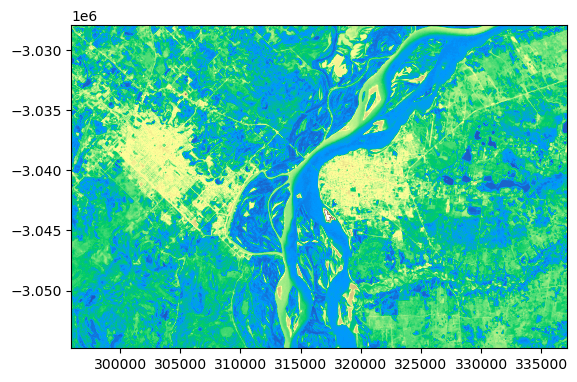

<Axes: >

In [59]:
""" clipped = rasterio.open(out_file)
show((clipped, 3), cmap='terrain') """